In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Import Libraries

In [ ]:
## Importing all the required libraries

import cv2     # for capturing videos
import os
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet50
from keras.layers import Input,Dense, InputLayer, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report


In [ ]:
import shutil

shutil.copyfile('/content/drive/MyDrive/eye_dataset.zip', './eye_dataset.zip')
!unzip eye_dataset.zip

#Dataset Preparation

In [ ]:
def label_img(img):
    word_label = img.split('_')[4]
    if word_label[0] == '1': return 1
    elif word_label[0] == '0': return 0
    #[1] eyes are open
    #[0] eyes are closed
    
def create_dataset(dir):
    dataset_path = []
    dataset_label = []
    for img in tqdm(os.listdir(dir)):
        label = label_img(img)
        if np.array(label) == 1:
            label_str = 'open'
        if np.array(label) == 0:
            label_str = 'close'
        path = os.path.join(dir, img)
        #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        dataset_path.append(path)
        dataset_label.append(label_str)
    df = pd.DataFrame()
    df['Path'] = dataset_path
    df['Label'] = dataset_label
    #np.save('train_data.npy', dataset)
    return df

In [ ]:
train_dir = '/content/Eye Dataset/Train_Data/'
test_dir = '/content/Eye Dataset/Test_Data/'
train_df = create_dataset(train_dir)
test_df = create_dataset(test_dir)

NameError: ignored

In [ ]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                validation_split=0.25)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
                dataframe=train_df,
                directory="/content/Eye Dataset/Train_Data/",
                x_col="Path",
                y_col="Label",
                subset="training",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="binary",
                target_size=(100,100))
val_gen = train_datagen.flow_from_dataframe(
                dataframe=train_df,
                directory="/content/Eye Dataset/Train_Data/",
                x_col="Path",
                y_col="Label",
                subset="validation",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="binary",
                target_size=(100,100))
test_gen = test_datagen.flow_from_dataframe(
                dataframe=test_df,
                directory="/content/Eye Dataset/Test_Data/",
                x_col="Path",
                y_col="Label",
                batch_size=32,
                seed=42,
                shuffle=False,
                class_mode="binary",
                target_size=(100,100))
print(train_gen.class_indices)
print(val_gen.class_indices)
print(test_gen.class_indices)


#Model

In [ ]:

# Initialize the VGG model

#base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape= (100,100,3),)
#base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=None, input_shape= (100,100,3),)
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape= (100,100,3),)


# Freeze all the layers
for layer in base_model.layers[:]:
    layer.trainable = True
    
# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(base_model)
model.add(Flatten())
#model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()
# Configure the model for training
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 31,976,833
Trainable params: 31,923,713
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:

model = Sequential()
model.add(Input(shape=(100,100,3)))

model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same'))

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same'))

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(GlobalAveragePooling2D())
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

# Configure the model for training
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      2432      
                                                                 
 batch_normalization_6 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      51264     
                                                                 
 batch_normalization_7 (Batc  (None, 100, 100, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 100, 100, 64)     

#Training

In [ ]:
weight_name = 'densenet121.h5'#########################################################################
weight_save_path = '/content/drive/MyDrive/Thesis/densenet121/weight/'

model_name='densenet121.h5'
model_save_path='/content/drive/MyDrive/Thesis/densenet121/model/'



lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=1e-9)
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=10, mode='min', restore_best_weights=True)
checkpoint1 = ModelCheckpoint(weight_save_path+weight_name, monitor='val_accuracy',save_best_only=True, save_weights_only=True)
checkpoint2 = ModelCheckpoint(model_save_path+model_name, monitor='val_accuracy',save_best_only=False, save_weights_only=False)
# Train the model
history = model.fit(
      train_gen,
      steps_per_epoch=(train_gen.samples)/train_gen.batch_size,
      validation_data=val_gen, 
      validation_steps=(val_gen.samples)/val_gen.batch_size,
      epochs=30,
      callbacks=[lr_reduce, checkpoint1,checkpoint2]
      )


#Testing

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Thesis/resnet50/model/resnet50_original.h5")
model.load_weights("/content/drive/MyDrive/Thesis/resnet50/weight/resnet50_original.h5")
#model.summary()

In [ ]:
#model.load_weights("/content/drive/MyDrive/Thesis/my try/weight/vgg16.h5")

In [ ]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()
pred=model.predict(test_gen,
steps=STEP_SIZE_TEST+1,
verbose=1)

455/455 [==============================] - 13s 25ms/step


In [ ]:
# import classification_report
from sklearn.metrics import classification_report

# get the ground truth of your data. 
test_labels=test_gen.classes 

# get the class with highest probability for each sample
y_pred = (pred > 0.5).astype(int)

report=classification_report(test_labels, y_pred,output_dict=True)
result_df = report
result_df = pd.DataFrame(result_df).transpose()

print(result_df)

              precision    recall  f1-score      support
0              0.980745  0.988326  0.984521   6339.00000
1              0.990934  0.985020  0.987968   8211.00000
accuracy       0.986460  0.986460  0.986460      0.98646
macro avg      0.985839  0.986673  0.986245  14550.00000
weighted avg   0.986495  0.986460  0.986466  14550.00000


CONFUSION MATRIX ------------------


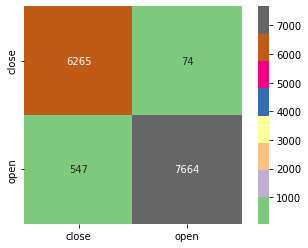

Sensitivity :  0.9883262344218331
Specificity :  0.9333820484715626


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from seaborn import heatmap
from matplotlib import pyplot as plt

cm = confusion_matrix(test_labels, y_pred)

 

print('CONFUSION MATRIX ------------------')

ax = heatmap(cm, cmap='Accent', annot=True, xticklabels=['close','open'], yticklabels=['close','open'], square=True, fmt='d')

plt.show()
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


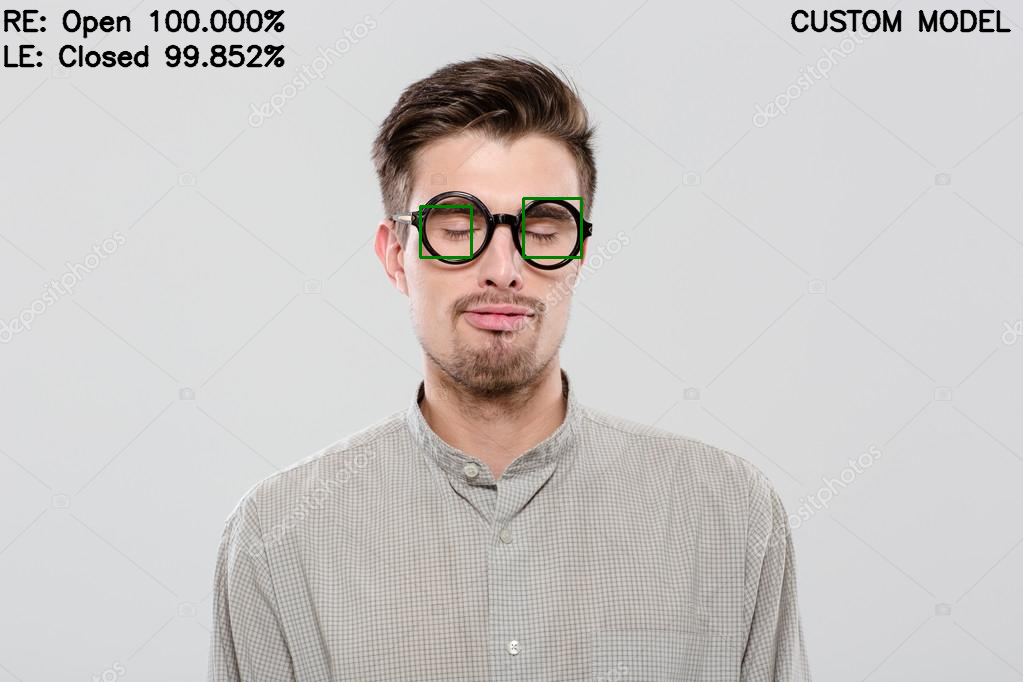

In [ ]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow

model_name = 'custom model'

model = keras.models.load_model("/content/drive/MyDrive/Thesis/"+model_name+"/model/"+model_name+"_original.h5")
model.load_weights("/content/drive/MyDrive/Thesis/"+model_name+"/weight/"+model_name+"_original.h5")


frequency = 2500  # Set Frequency To 2500 Hertz
duration = 50

IMG_SIZE = (100, 100)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Thesis/shape_predictor_68_face_landmarks.dat')

font                   = cv2.FONT_HERSHEY_SIMPLEX
position = (2,30)
fontScale              = 0.9
fontColor              = (0,0,0)
lineType               = 2
line_type = cv2.LINE_AA
thickness = 2


def crop_eye(img, eye_points):
  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * IMG_SIZE[1] / IMG_SIZE[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_img = img[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

  return eye_img, eye_rect

# main
#cap = cv2.VideoCapture('http://192.168.0.103:8080/video')

img_ = cv2.imread('/content/drive/MyDrive/Thesis/close_eye_glass.jpg')##################################################3


img_ori = cv2.resize(img_, dsize=(0, 0), fx=1, fy=1)

img = img_ori.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = detector(gray)


for (i,face) in enumerate(faces):
  shapes = predictor(gray, face)
  shapes = face_utils.shape_to_np(shapes)

  eye_img_l, eye_rect_l = crop_eye(img_ori, eye_points=shapes[36:42])
  eye_img_r, eye_rect_r = crop_eye(img_ori, eye_points=shapes[42:48])


  eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
  eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
  eye_img_l = cv2.flip(eye_img_l, flipCode=1)

  eye_input_l = eye_img_l/255
  eye_input_r = eye_img_r/255
  

  pred_left = model.predict(eye_input_l[np.newaxis, :, :])
  pred_right = model.predict(eye_input_r[np.newaxis, :, :])

    # visualize
  state_l = 'Closed' if pred_left < 0.3 else 'Open'
  state_r = 'Closed' if pred_right < 0.35 else 'Open'

  if pred_left < 0.5:
    pred_l = 1- pred_left
  elif pred_left >= 0.5:
    pred_l = pred_left
  pred_l_str = "{:.3f}".format(pred_l[0][0]*100)
  if pred_right < 0.5:
    pred_r = 1- pred_right
  elif pred_left >= 0.5:
    pred_r = pred_right
  pred_r_str = "{:.3f}".format(pred_r[0][0]*100)

  state_l = state_l + ' '+pred_l_str+'%'
  state_r = state_r + ' '+pred_r_str+'%'
  

  
  text='RE: '+state_r+'\n'+'LE: '+state_l
  text_size, _ = cv2.getTextSize(text, font, fontScale, thickness)
  line_height = text_size[1] + 15
  x_text, y0_text = position
  for i, line in enumerate(text.split("\n")):
      y_text = y0_text + i * line_height
      cv2.putText(img,line,(x_text, y_text),font,fontScale,fontColor,thickness,line_type)
  cv2.putText(img,model_name.upper(),(790,30),font,fontScale,fontColor,thickness,line_type)

  
  
  if pred_l > 0.1:
      color_l=(0,128,0)
  else:
      color_l=(0,0,255)
  if pred_r > 0.1:
      color_r=(0,128,0)
  else:
      color_r=(0,0,255)
  

  cv2.rectangle(img, tuple(eye_rect_l[0:2]), tuple(eye_rect_l[2:4]), color_l, 2)
  cv2.rectangle(img, tuple(eye_rect_r[0:2]),tuple(eye_rect_r[2:4]), color_r, 2)

  #cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
  #cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

cv2_imshow(img)



#Webcam

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
IMG_SIZE = (100,100)
def crop_eye(img, eye_points):
  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * IMG_SIZE[1] / IMG_SIZE[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_img = img[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

  return eye_img, eye_rect

In [ ]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model
import imutils


# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

IMG_SIZE = (100, 100)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Thesis/shape_predictor_68_face_landmarks.dat')

font                   = cv2.FONT_HERSHEY_SIMPLEX
position = (25,100)
fontScale              = 0.7
fontColor              = (0,128,0)
lineType               = 2
line_type = cv2.LINE_AA
thickness = 2


while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img_ori = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=1, fy=1)
    img = img_ori.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for (i,face) in enumerate(faces):
        shapes = predictor(gray, face)
        shapes = face_utils.shape_to_np(shapes)

        eye_img_l, eye_rect_l = crop_eye(img_ori, eye_points=shapes[36:42])
        eye_img_r, eye_rect_r = crop_eye(img_ori, eye_points=shapes[42:48])

        eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
        eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
        #eye_img_r = cv2.flip(eye_img_r, flipCode=1)

        eye_input_l = eye_img_l/255
        eye_input_r = eye_img_r/255
        pred_left = model.predict(eye_input_l[np.newaxis, :, :])
        pred_right = model.predict(eye_input_r[np.newaxis, :, :])

         # visualize
        state_l = 'Closed' if pred_left < 0.3 else 'Open'
        state_r = 'Closed' if pred_right < 0.35 else 'Open'

        if pred_left < 0.5:
          pred_l = 1- pred_left
        elif pred_left >= 0.5:
          pred_l = pred_left

        if pred_right < 0.5:
          pred_r = 1- pred_right
        elif pred_left >= 0.5:
          pred_r = pred_right

        state_l = state_l % pred_l
        state_r = state_r % pred_r
        
        if pred_left < 0.2 or pred_right < 0.2:
            count=count+1
            #print(count)
        else:
            count=0
            
        count_text='Duration: '+str(count)
        warning='WARNING!!!!'
        
        text='Right Eye: '+state_r+'\n'+'Left Eye: '+state_l
        text_size, _ = cv2.getTextSize(text, font, fontScale, thickness)
        line_height = text_size[1] + 15
        x_text, y0_text = position
        for i, line in enumerate(text.split("\n")):
            y_text = y0_text + i * line_height
            bbox_array = cv2.putText(bbox_array,line,(x_text, y_text),font,fontScale,fontColor,thickness,line_type)
        if count > 3:
            bbox_array = cv2.putText(bbox_array,count_text,(25, 170),font,fontScale,fontColor,thickness,line_type)
        
        if count > 10:
            bbox_array = cv2.putText(bbox_array,warning,(25, 300),font,1.5,(0,0,255),3,line_type)
            
        if pred_l > 0.1:
            color_l=(0,128,0)
        else:
            color_l=(0,0,255)
        if pred_r > 0.1:
            color_r=(0,128,0)
        else:
            color_r=(0,0,255)
        

        bbox_array = cv2.rectangle(bbox_array, tuple(eye_rect_l[0:2]), tuple(eye_rect_l[2:4]), color_l, 2)
        bbox_array = cv2.rectangle(bbox_array, tuple(eye_rect_r[0:2]),tuple(eye_rect_r[2:4]), color_r, 2)

        #cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        #cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)



    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


#Visualization

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_TWILIGHT):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)
    

0


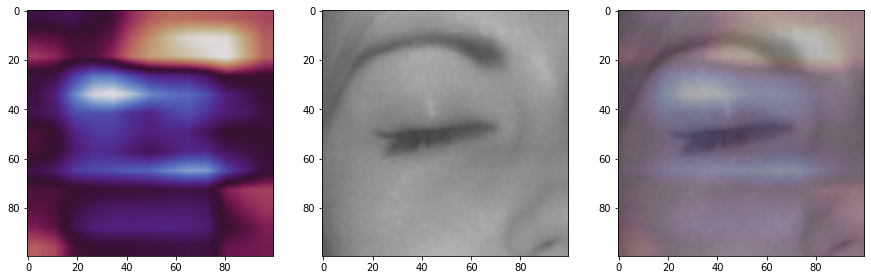

In [ ]:
image = cv2.imread('/content/Eye Dataset/Train_Data/s0016_00601_1_0_0_0_1_01.png')
image = cv2.resize(image, (100, 100))
image_ = image.astype('float32') / 255
image_ = np.expand_dims(image_, axis=0)


preds = model.predict(image_) 
y_pred = (preds > 0.5).astype(int)
i=y_pred[0][0]
print(i)
icam = GradCAM(model, i, 'conv2d_27') 
heatmap = icam.compute_heatmap(image_)
heatmap = cv2.resize(heatmap, (100, 100))

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.7)
from matplotlib.pyplot import figure


fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

conv2d_21
batch_normalization_21
activation_21
conv2d_22
batch_normalization_22
activation_22
conv2d_23
batch_normalization_23
activation_23
conv2d_24
batch_normalization_24
activation_24
max_pooling2d_9
conv2d_25
batch_normalization_25
activation_25
max_pooling2d_10
conv2d_26
batch_normalization_26
activation_26
max_pooling2d_11
conv2d_27
batch_normalization_27
activation_27
global_average_pooling2d_3
dense_11
dropout_4
dense_12
dense_13


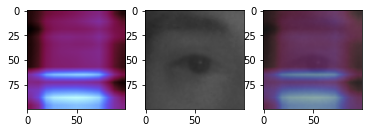